# Multidimensional Metropolis-Hastings and Importance Sampling
This notebook demonstrates how to use the Metropolis-Hastings algorithm and importance sampling to estimate integrals in an arbitrary number of dimensions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import Generator, MT19937
import time

# Initialize random number generator
seed = int(time.time())
rng = Generator(MT19937(seed))

In [ ]:
# User-defined target PDF (multivariate standard normal by default)
def target_pdf(x):
    x = np.asarray(x)
    return np.exp(-0.5 * np.sum(x**2, axis=-1)) / (2 * np.pi) ** (x.shape[-1]/2)

# User-defined function to integrate (default: exp(-sum(x**2)))
def f(x):
    x = np.asarray(x)
    return np.exp(-np.sum(x**2, axis=-1))

# Multidimensional Metropolis-Hastings sampler
def metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf):
    d = len(x0)
    samples = []
    x_current = np.array(x0)
    for _ in range(N):
        x_proposed = x_current + rng.uniform(-step_size, step_size, size=d)
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current)
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
        samples.append(x_current.copy())
    samples = samples[::thinning] #Keep every 'thinning'-th sample
    samples = samples[burnin:] #Discard the firs 'burnin' samples
    return np.array(samples)

# Importance sampling integration for multidimensional case
def importance_integration(f, target_pdf, m_chain):
    weights = f(m_chain) / target_pdf(m_chain)
    estimate = np.mean(weights)
    return estimate

# Example Usage

In [363]:
# Example usage: choose dimension d
D = 2  # Change this for different dimensions
N = 100_000
x0 = np.zeros(D)
step_size = 3.0
thinning = 1
burnin = int(N * 0.1)

m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)
Integral = importance_integration(f, target_pdf, m_chain)
print(f"Estimated integral in {D}D: {Integral}")
print("Actual value is ", np.pi ** (D/2))

Estimated integral in 2D: 3.1263555835803274
Actual value is  3.141592653589793


# Integral Estimate vs N for a chosen dimension

In [28]:

# Plot convergence of the estimated value to the actual value of pi^(3/2) for D=3
D = 10
actual_value = np.pi ** (D / 2)
N_values = np.logspace(2, 6, 30, dtype=int)
num_repeats = 10  # Number of repeated runs for error bars
integral_estimates = []
std_errors = []

x0 = np.zeros(D)
step_size = 3.0
thinning = 1


for N in N_values:
    estimates = []
    for _ in range(num_repeats):
        m_chain = metropolis_hastings(x0, thinning, int(0.1*N), N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    integral_estimates.append(np.mean(estimates))
    std_errors.append(np.std(estimates) / np.sqrt(num_repeats))



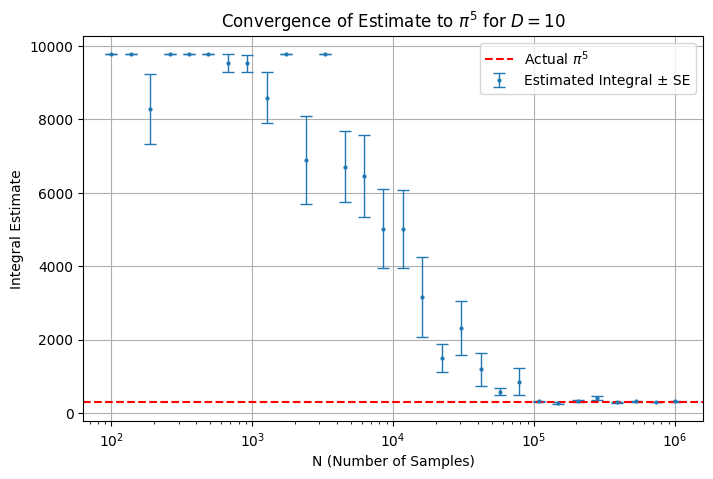

In [31]:

#Plot

plt.figure(figsize=(8, 5))
plt.errorbar(N_values, integral_estimates, yerr=std_errors, fmt='o', markersize=2, capsize=4, elinewidth=1, capthick=1, label='Estimated Integral ± SE')
plt.axhline(y=actual_value, color='red', linestyle='--', label=r'Actual $\pi^{5}$')
plt.xscale('log')
plt.xlabel('N (Number of Samples)')
plt.ylabel('Integral Estimate')
plt.title(r'Convergence of Estimate to $\pi^{5}$ for $D=10$')
plt.legend()
plt.grid(True)
plt.show()

# Integral Estimate vs Step Size

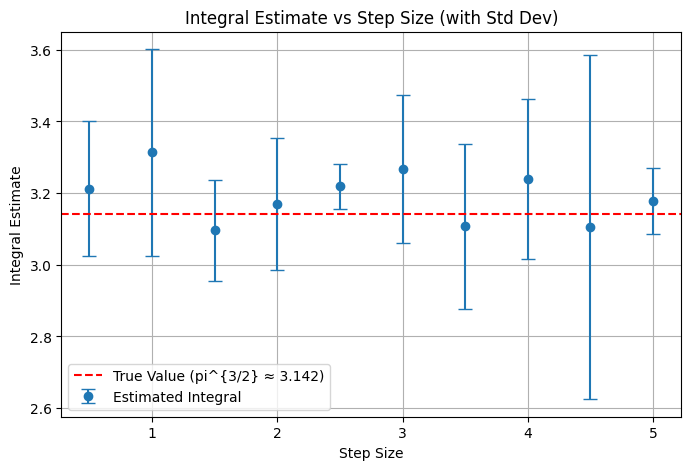

In [ ]:

# Vary the step size, compute the integral multiple times for each, and show deviation from the true value
D = 2
N = 1_000
x0 = np.zeros(D)
thinning = 1
burnin = int(N * 0.1)
actual_value = np.pi ** (D/2)

step_sizes = np.linspace(0.5, 5.0, 10)
repeats = 5  # Number of runs per step size
means = []
stds = []

for step_size in step_sizes:
    estimates = []
    for _ in range(repeats):
        m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    means.append(np.mean(estimates))
    stds.append(np.std(estimates))

plt.figure(figsize=(8, 5))
plt.errorbar(step_sizes, means, yerr=stds, fmt='o', markersize=6, capsize=5, label='Estimated Integral')
plt.axhline(y=actual_value, color='red', linestyle='--', label=f'True Value ($pi^{3/2}$)')
plt.xlabel('Step Size')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs Step Size (with Std Dev)')
plt.legend()
plt.grid(True)
plt.show()


# Visualize how the integral estimate evolves during the burn-in period

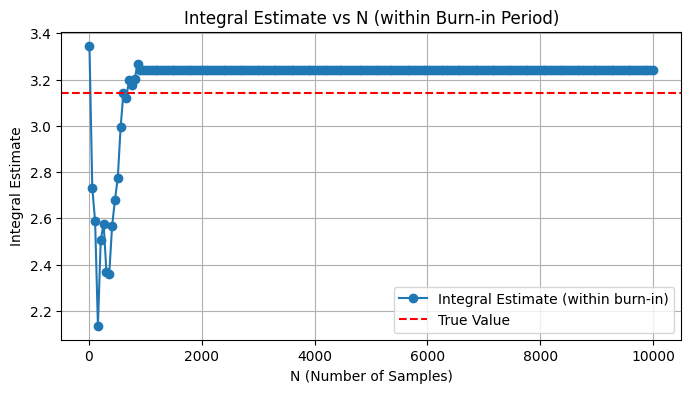

In [24]:
# Visualize how the integral estimate evolves during the burn-in period

burn_in = 10_000
N_checkpoints = np.linspace(10, burn_in, 200, dtype=int)
estimates = []

for n in N_checkpoints:
    # Estimate the integral using the first n samples (within burn-in)
    values = [f(x) / target_pdf(x) for x in m_chain[:n]] if 'm_chain' in locals() else []
    if values:
        estimate = np.mean(values)
        estimates.append(estimate)
    else:
        estimates.append(np.nan)

actual_value = np.pi ** (D/2) if 'D' in locals() else 1.0

plt.figure(figsize=(8, 4))
plt.plot(N_checkpoints, estimates, marker='o', label='Integral Estimate (within burn-in)')
plt.axhline(y=actual_value, color='red', linestyle='--', label='True Value')
plt.xlabel('N (Number of Samples)')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs N (within Burn-in Period)')
plt.legend()
plt.grid(True)
plt.show()

# Heat Map of Markov Chain vs Analytical Target pdf

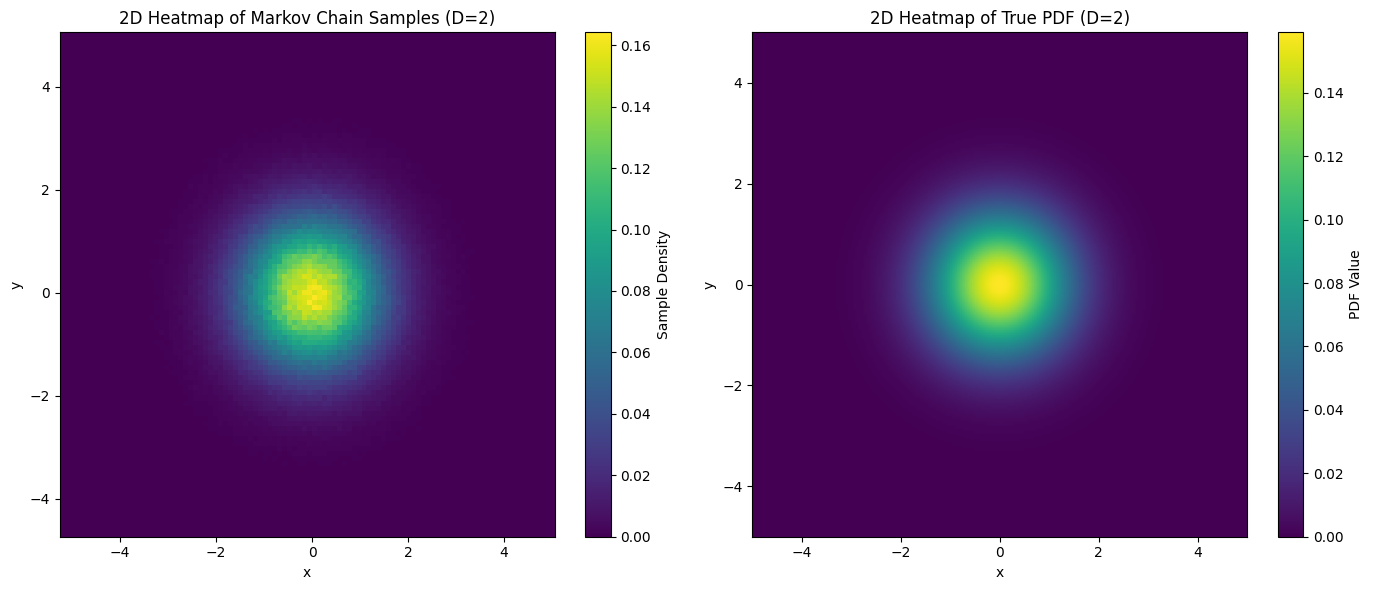

"\nplt.figure(figsize=(7, 6))\nplt.hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)\nplt.colorbar(label='Sample Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('2D Heatmap of Markov Chain Samples (D=2)')\nplt.show()\n"

In [367]:
# Only run for D=2
D = 2
N = 10_000_000
x0 = np.zeros(D)
step_size = 3.0
thinning = 1
burnin = int(N * 0.1)

m_chain = metropolis_hastings(x0, thinning, burnin, N, step_size, target_pdf)

# Extract x and y coordinates
x_vals = m_chain[:, 0]
y_vals = m_chain[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Markov chain sample heatmap
h1 = axs[0].hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)
plt.colorbar(h1[3], ax=axs[0], label='Sample Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('2D Heatmap of Markov Chain Samples (D=2)')

# Plot true PDF heatmap
grid_size = 200
x_grid = np.linspace(-5, 5, grid_size)
y_grid = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X, Y))
Z = target_pdf(pos)

im = axs[1].imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im, ax=axs[1], label='PDF Value')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('2D Heatmap of True PDF (D=2)')

plt.tight_layout()
plt.show()
"""
plt.figure(figsize=(7, 6))
plt.hist2d(x_vals, y_vals, bins=100, cmap='viridis', density=True)
plt.colorbar(label='Sample Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Heatmap of Markov Chain Samples (D=2)')
plt.show()
"""
